In [1]:
import json
import time
import os

from pymongo import MongoClient

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import line_profiler

from imputation import *
from solve_cubic import *

%load_ext line_profiler
%load_ext Cython
%matplotlib inline

client = MongoClient("localhost", 27017)
db = client['usgs']

In [2]:
to_shift = {
    14137000 : -687,
    7377500  : +2,
    8186500  : +2,
    11456000 : +2
}


def align_measurements(t_meas, y_meas, t_corr, y_corr):
    dt_corr, n_corr = np.unique(t_corr[1:] - t_corr[:-1], return_counts=True)
    dt_meas, n_meas = np.unique(t_meas[1:] - t_meas[:-1], return_counts=True)
    dt = min(dt_corr[np.argmax(n_corr)], dt_meas[np.argmax(n_meas)])
    
    offset_corr = max(t_corr[0] - t_meas[0], 0)
    offset_meas = max(t_meas[0] - t_corr[0], 0)
    N = (max(t_corr[-1], t_meas[-1]) - min(t_corr[0], t_meas[0])) // dt + 1
    
    y_corr_new = np.zeros(N) - 1
    y_meas_new = np.zeros(N) - 1
    
    idx_corr = np.cumsum((t_corr[1:] - t_corr[:-1]) // dt) + offset_corr // dt
    idx_meas = np.cumsum((t_meas[1:] - t_meas[:-1]) // dt) + offset_meas // dt
    
    y_corr_new[idx_corr] = y_corr[1:]
    y_meas_new[idx_meas] = y_meas[1:]
    
    y_corr_new[0] = y_corr[0]
    y_meas_new[0] = y_meas[0]
    
    return y_meas_new, y_corr_new


def get_data(db, site_id):
    data_m = db['measured'].find_one({'site_no': site_id})
    data_c = db['corrected'].find_one({'site_no': site_id})
    
    if data_m is None or data_c is None:
        raise Exception("Site not found")
        
    Tm = np.array(data_m['utc'], dtype=np.int32)
    Zm = np.array(data_m['gh'],  dtype=np.float32)
    
    Tc = np.array(data_c['utc'], dtype=np.int32)
    Zc = np.array(data_c['gh'],  dtype=np.float32)
    
    if site_id in to_shift:
        Zm += to_shift[site_id]
        Zc += to_shift[site_id]
    
    return Tm, Zm, Tc, Zc


def mark_anomaly(y_m, y_c, anomaly_thresh):
    return np.logical_or(y_c < 0, np.abs(y_c - y_m) > anomaly_thresh)  

In [3]:
sites = db['cites']
measured = db['measured']
corrected = db['corrected']

cursor = sites.find()
sid = [c['site_no'] for c in cursor]

In [ ]:
good_list = [14211550, 5124480, 1658500, 2378500, 8078000, 16103000, 7151500, 6479010, 4185000, 2198000, 8109700, 2422500,
             3574500, 2318700, 2361000, 3543500, 2233500, 12321500]

In [ ]:
n_b = 1000
H = np.zeros(n_b)

for i in range(len(sid)):
    try:
        _, _, Tc, Zc = get_data(db, sid[i])
    except:
        pass
    
    dZc = (Zc[1:] - Zc[:-1]) / (Tc[1:] - Tc[:-1])
    h, b = np.histogram(dZc, bins = n_b, range = (-0.01, 0.01))
    H += h
    if i % 10 == 0:
        print(i, sid[i])

In [ ]:
plt.plot(b[:-1], H / H.sum())
plt.xlim(-0.0005, 0.001)

In [ ]:
b = np.linspace(-0.01,0.01,1001)
n = np.where(b > -0.0005)[0][0]
k = np.where(b <  0.0005)[0][-1]

H[:n].sum() / H.sum() + H[k:].sum() / H.sum()

In [4]:
def confusion_matrix(y_true, y_pred):
    TN = np.logical_and(np.logical_not(y_true), np.logical_not(y_pred))
    TP = np.logical_and(y_true, y_pred)
    FN = np.logical_and(y_true, np.logical_not(y_pred))
    FP = np.logical_and(np.logical_not(y_true), y_pred)
    cm = np.array([[TN, FP],[FN, TP]])
    return cm

In [5]:
def func():
    si = sid[23]

    Tm, Zm, Tc, Zc = get_data(db, si)
    dt = min((Tc[1:] - Tc[:-1]).min(), (Tm[1:] - Tm[:-1]).min())

    abs_thresh = np.median(Zm) + 15*np.subtract(*np.percentile(Zm, [90, 10]))
    dy_thr_max = +0.0010
    dy_thr_min = -0.0005
    Zm[Zm <= 0] = -1

    Ym, Yc = align_measurements(Tm, Zm, Tc, Zc)
    Qm = fill_gaps(Ym, max_gap = 2000, spike_size = 2, window_size = 1 * 86400 // dt)
    Qc = fill_gaps(Yc, max_gap = 2000, spike_size = 2, window_size = 1 * 86400 // dt)
    dQm = np.hstack([0, (Qm[1:] - Qm[:-1]) / dt])
    y_true = mark_anomaly(Qm, Qc, 0.05)
    y_pred = np.logical_or(dQm > dy_thr_max, dQm < dy_thr_min)
    
    cm = confusion_matrix(y_true, y_pred)

In [ ]:
%lprun -f fill_gaps func()

In [31]:
%%cython
import cython
import numpy as np
cimport numpy as np

cdef extern from "complex.h":
    double complex I
    double complex csqrt(double complex z) nogil   
    double sqrt(double z) nogil   
    
cdef struct roots:
    double complex r0
    double complex r1
    double complex r2
    
ctypedef np.float64_t DTYPE_t

@cython.cdivision(True)
cdef roots solve_cubic(float a, float b, float c, float d):
    cdef roots res
    if a == 0 and b == 0:
        res.r0 = <double complex>(-d/c)
        res.r1 = <double complex>(-d/c)
        res.r1 = <double complex>(-d/c)
        return res
    
    cdef:
        double D0 = b*b - 3*a*c
        double D1 = 2*b*b*b - 9*a*b*c + 27*a*a*d
        double D2 = D1*D1 - 4*D0*D0*D0
        double complex D3 = csqrt(D2)   
        double complex D4 = D1 + D3 
        double complex D5 = D4 if D4 != 0 else D1 - D3    
        double complex C = (0.5*D5) ** 0.3333333333333333
        double complex k = -0.5 - 0.8660254037844386j # -1/2 - 1/2*np.sqrt(3)j
        
    # r_i = -(b + C*k**i + D0 / (C*k**i)) / (3*a)
    res.r0 = -(b + C + D0 / C) / (3*a)            # i = 0
    res.r1 = -(b + C*k + D0 / (C*k)) / (3*a)      # i = 1
    res.r2 = -(b + C*k*k + D0 / (C*k*k)) / (3*a)  # i = 2
    return res


@cython.boundscheck(False)
@cython.wraparound(False)
def bezier_interpolator(double x_a, double y_a, double dy_a, 
                        double x_b, double y_b, double dy_b, 
                        x, 
                        double eps = 1e-10):
    
    cdef: 
        int n = x.size
        double x_1, x_2, y_1, y_2
        double c_3, c_2, c_1, c_0
        roots R
     
    if n == 2:
        By = np.array([y_a, 0.5*(y_a + y_b)])
    
    else:
        # cubic bezier curve
        x_1 = x[n // 3]  
        x_2 = x[n - n // 3] 
        y_1 = y_a + dy_a*(x_1 - x_a)        
        y_2 = y_b + dy_b*(x_2 - x_b)        
        t = np.zeros(n)
        
        c_3 = x_b - 3*x_2 + 3*x_1 - 1*x_a
        c_2 =       3*x_2 - 6*x_1 - 3*x_a 
        c_1 =               3*x_1 - 3*x_a 
        c_0 =                       1*x_a
        
        for i in range(n):
            c_0 = x_a - x[i]
            R = solve_cubic(c_3, c_2, c_1, c_0)

            if abs(R.r0.imag) < eps and -eps <= R.r0.real <= 1+eps:
                t[i] = R.r0.real
                
            elif abs(R.r1.imag) < eps and -eps <= R.r1.real <= 1+eps:
                t[i] = R.r1.real
                
            elif abs(R.r2.imag) < eps and -eps <= R.r2.real <= 1+eps:
                t[i] = R.r2.real
                
            else:
                raise Exception("Bezier interpolation: no real solution found.")
            
        By = (1-t)**3 * y_a + 3*t*(1-t)**2 * y_1 + 3*(1-t)*t**2 * y_2 + t**3 * y_b
        
    return By


@cython.cdivision(True)
cdef double get_bisector(double x, double y, 
                         double xl, double yl, 
                         double xr, double yr):
    cdef double x1 = x - xl
    cdef double y1 = y - yl
    cdef double x1_n = sqrt(x1*x1 + y1*y1)

    cdef double x2 = xr - x
    cdef double y2 = yr - y
    cdef double x2_n = sqrt(x2*x2 + y2*y2)
    
    cdef double y3 = (y1 / x1_n + y2 / x2_n) / (x1 / x1_n + x2 / x2_n)
    return y3

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def fill_gaps(y, int max_gap=10000, int spike_size=2, int window_size=10):
    
    cdef: 
        
        double dy_a, dy_b
        int a = 0, b = 0, p = 0, q = 0, i = 0, j = 0, k = 0
        int n = y.size
        int gap_size = 0

    z = y.copy()
        
    for i in range(1, n):
        
        if y[i] > 0:
            a = b; b = i  # a, b are non-negative gap bounds          
            
            if b - a > 1 and gap_size < max_gap:                
                # left bounding condition
                j = 0
                while ( y[a - j] > 0 and a - j > 0 and j < window_size ) : 
                    j += 1

                if j <= spike_size:
                    p = 0
                    while ( y[a - j - p] < 0 and j + p < max_gap ) : p += 1
                    dy_a = get_bisector(a, y[a], a-j-p, y[a-j-p], b, y[b])                     
                else:
                    p = 0
                    dy_a = (y[a] - y[a-j+1]) / j  

                #right bounding condition
                k = 0
                while ( y[b + k] > 0 and b + k < n-1 and k < window_size ) : 
                    k += 1     
                
                if k <= spike_size:    
                    q = 0
                    while ( y[b + k + q] < 0 and k + q < max_gap ) : q += 1
                    dy_b = get_bisector(b, y[b], a, y[a], b + k + q, y[b + k + q])                     
                else:
                    q = 0
                    dy_b = (y[b + k - 1] - y[b]) / k
                    
                z[a:b] = bezier_interpolator(0, y[a], dy_a, b-a, y[b], dy_b, np.arange(b-a))
                
            gap_size = 0
            
        else:
            gap_size += 1
                
    return z

In [33]:
%%timeit
fill_gaps_cyth(Ym)

100 loops, best of 3: 3.35 ms per loop


In [13]:
%%timeit
fill_gaps(Ym)

10 loops, best of 3: 67.6 ms per loop


1601500


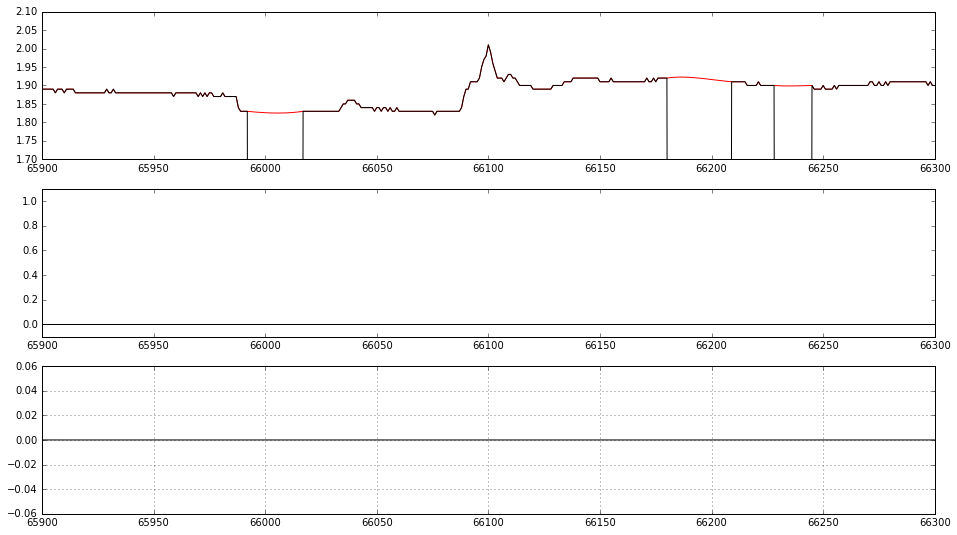

In [25]:
si = sid[23]

Tm, Zm, Tc, Zc = get_data(db, si)
dt = min((Tc[1:] - Tc[:-1]).min(), (Tm[1:] - Tm[:-1]).min())

abs_thresh = np.median(Zm) + 15*np.subtract(*np.percentile(Zm, [90, 10]))
dy_thr_max = +0.0010
dy_thr_min = -0.0005
Zm[Zm <= 0] = -1

Ym, Yc = align_measurements(Tm, Zm, Tc, Zc)
Qm = fill_gaps(Ym, max_gap = 2000, spike_size = 2, window_size = 1 * 86400 // dt)
Qc = fill_gaps(Yc, max_gap = 2000, spike_size = 2, window_size = 1 * 86400 // dt)
dQm = np.hstack([0, (Qm[1:] - Qm[:-1]) / dt])
y_true = mark_anomaly(Qm, Qc, 0.05)
y_pred = np.logical_or(dQm > dy_thr_max, dQm < dy_thr_min)

plt.figure(figsize = (16,9))

x1 = 65900
x2 = 66300
plt.subplot(3,1,1)
plt.plot(Qm, 'r-')
plt.plot(Ym, 'k-')
plt.ylim(1.7,2.1)
plt.xlim(x1, x2)

plt.subplot(3,1,2)
plt.plot(mark_anomaly(Qm, Qc, 0.05), 'k-')
plt.ylim(-0.1,1.1)
plt.xlim(x1, x2)

plt.subplot(3,1,3)
plt.plot(dQm, 'k-')
plt.xlim(x1, x2)
plt.grid()

print(si)

In [ ]:
confusion_matrix(y_true, y_pred)

In [ ]:
plt.figure(figsize = (16,3))

plt.plot(y_true, 'k-')
plt.plot(y_pred, 'r-')

#plt.xlim(45900, 46000)
plt.ylim(-0.1, 1.1)


In [ ]:
plt.figure(figsize = (16,3))
plt.plot(Ym, 'b.-')
plt.plot(Qm, 'r-')
plt.ylim(23,34)
#plt.xlim(109750, 109800)

plt.figure(figsize = (16,3))
plt.plot(dZ, 'r.-')
#plt.plot(ddZ, 'b.-')
plt.ylim(-0.0005,0.0007)
#plt.xlim(109750, 109800)
print(si)